In [1]:
# UPORABNO:
# Povezava: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [26]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

In [69]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day
DateTimeStartUTC,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01
...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29


In [71]:
## Številki opis podatkov:
df = pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))
df

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,3629.32,28736.8,12240.501427,11708.45,4167.961058


In [8]:
## Vizualizacija
sns.set(rc={'figure.figsize':(20, 5)}) # sets the default figure size

<AxesSubplot: xlabel='DateTimeStartCET'>

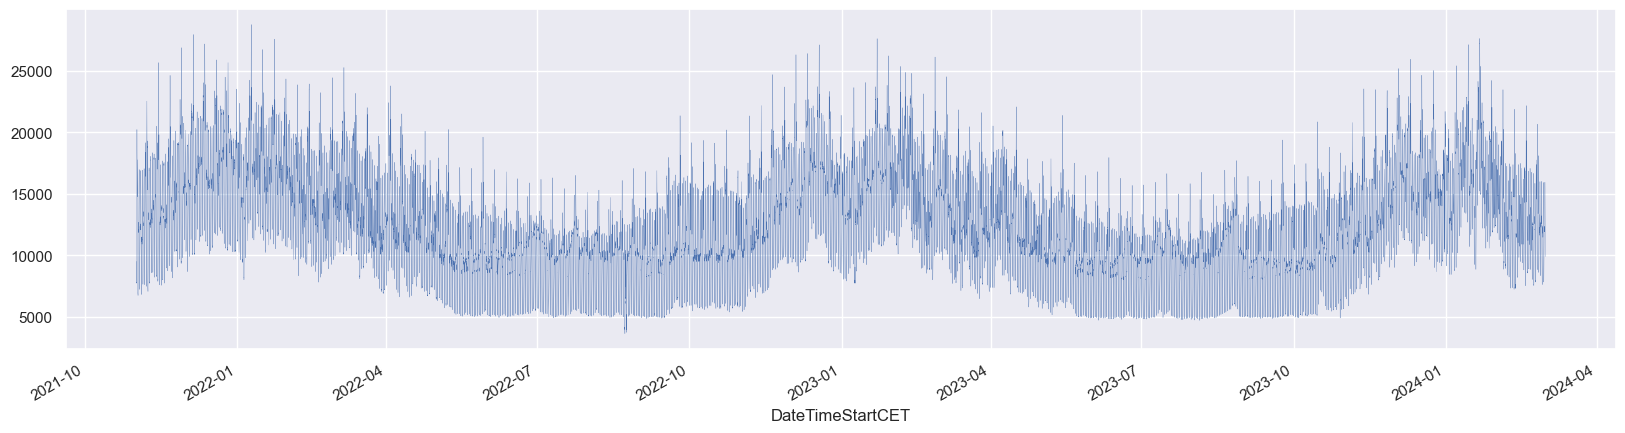

In [48]:
podatki['Odjem ACT'].plot(linewidth=0.2)

<AxesSubplot: xlabel='DateTimeStartCET'>

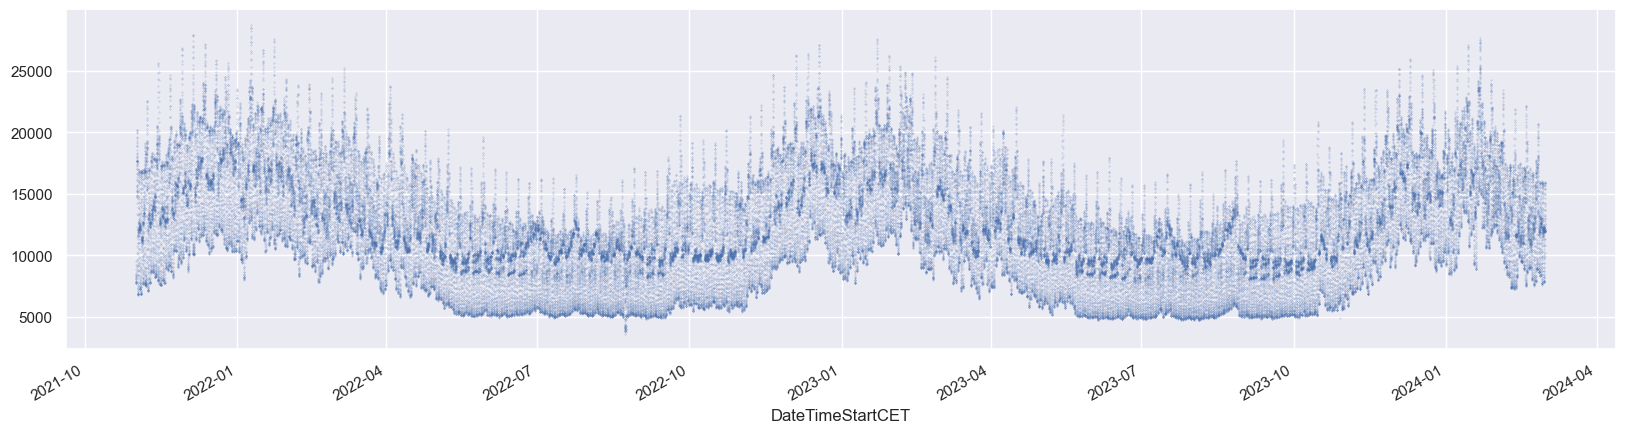

In [49]:
podatki['Odjem ACT'].plot(marker='.', alpha=0.5, linestyle='None', ms=0.5)
# iz tega grafa je malo boljše lažje razbrat stvari

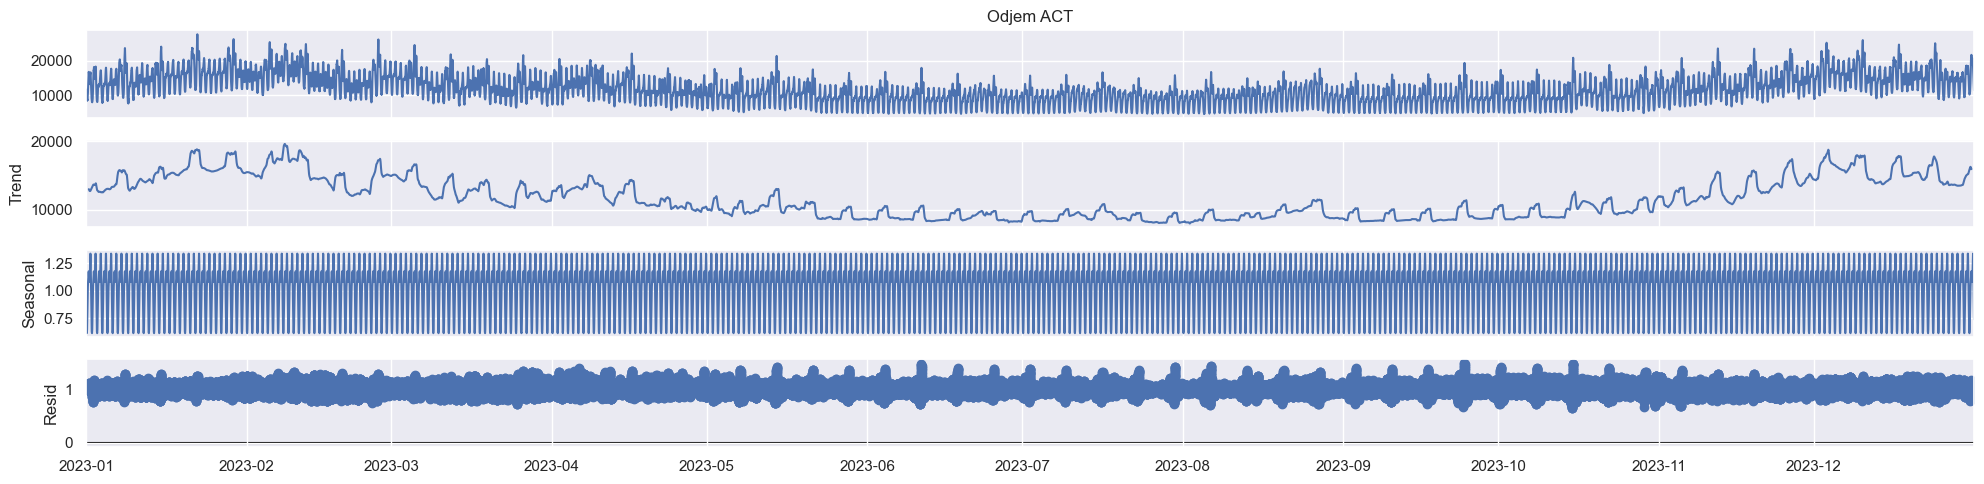

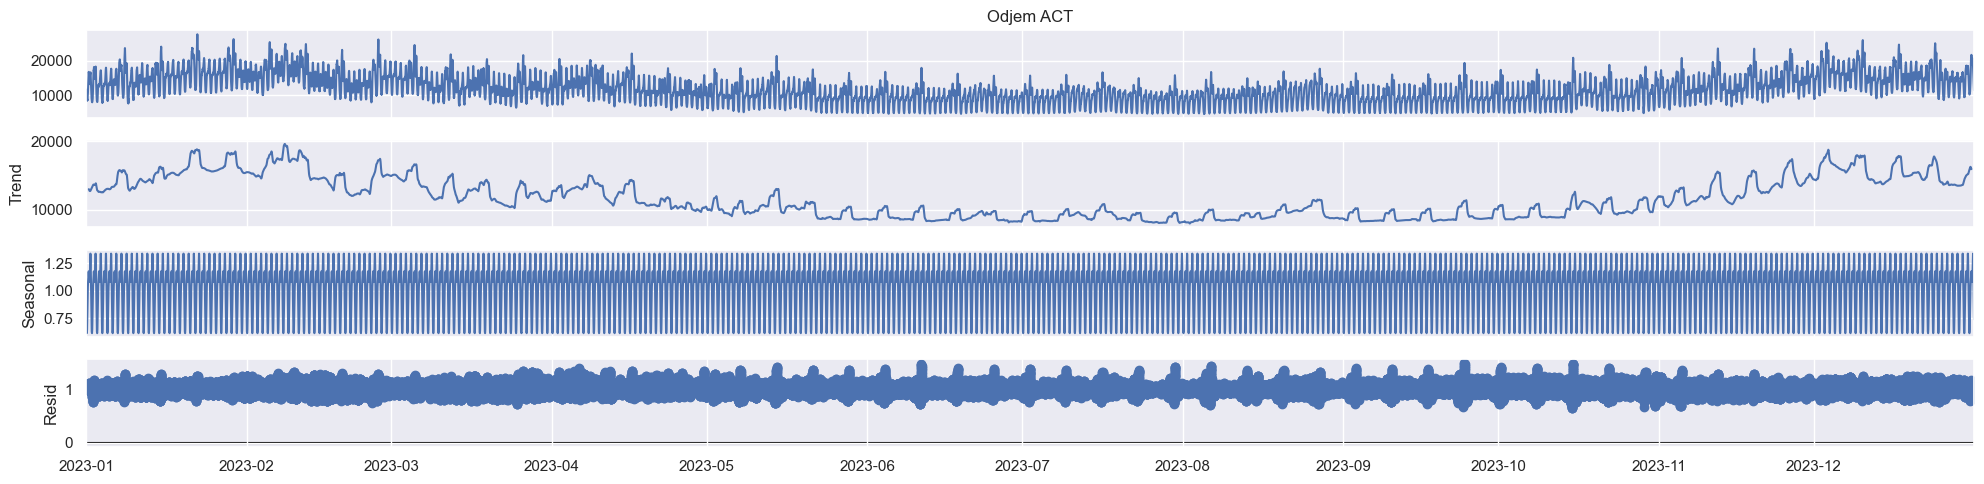

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose

podatki_dec = podatki['Odjem ACT']
podatki_dec
decomp = seasonal_decompose(podatki.loc['2023', 'Odjem ACT'], model='multiplicative', period=96)
decomp.plot()

In [49]:
# opazke:
# - poraba je večja v zimskih mesecih
# - poraba se v času božičnih praznikov (konec decembra, začetek januarja) zmanjša
# - tisto kar je blizu nič predstavlja porabo tekom noči

<AxesSubplot: xlabel='DateTimeStartCET'>

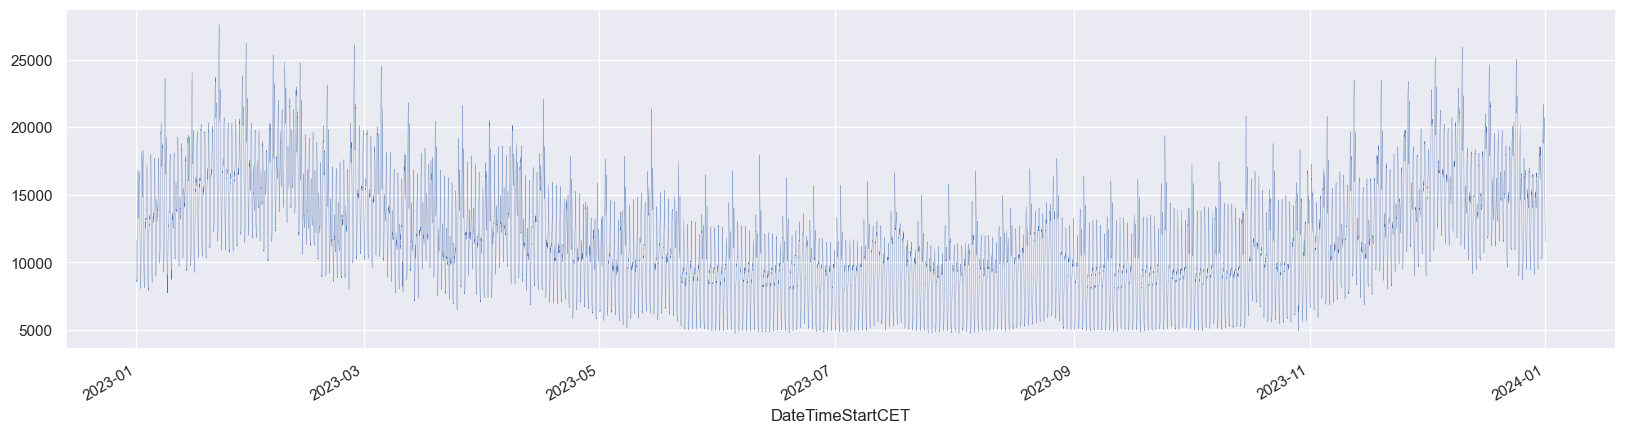

In [51]:
## odjem leta 2023:
podatki.loc['2023', 'Odjem ACT'].plot(linewidth=0.2)

In [43]:
# odjem za en teden
# podatki.loc['2022-03-01':'2022-03-07', 'Odjem ACT'].plot(marker='o', linestyle='-', linewidth=1, ms=3)

In [ ]:
## NAREDIMO ČASOVNO VRSTO STACIONARNO

# očitno je, da vrsta NI stacionarna

<AxesSubplot: xlabel='DateTimeStartCET'>

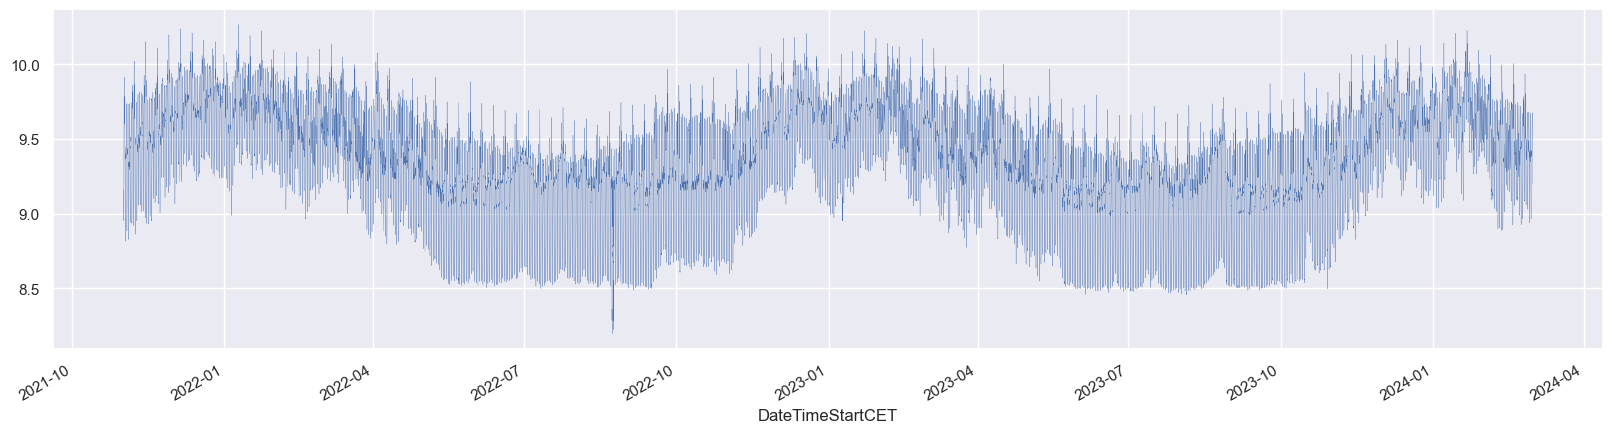

In [9]:
# Podatki so volatilni, zato najprej naredimo logaritemsko transformacijo (log(D_t)). Tako se vse malo bolj stabilizira 
podatki['Logaritem'] = np.log(podatki['Odjem ACT'])
podatki['Logaritem'].plot(linewidth=0.2)

Text(0.5, 1.0, 'Logaritem časovne vrste odjema, 2023')

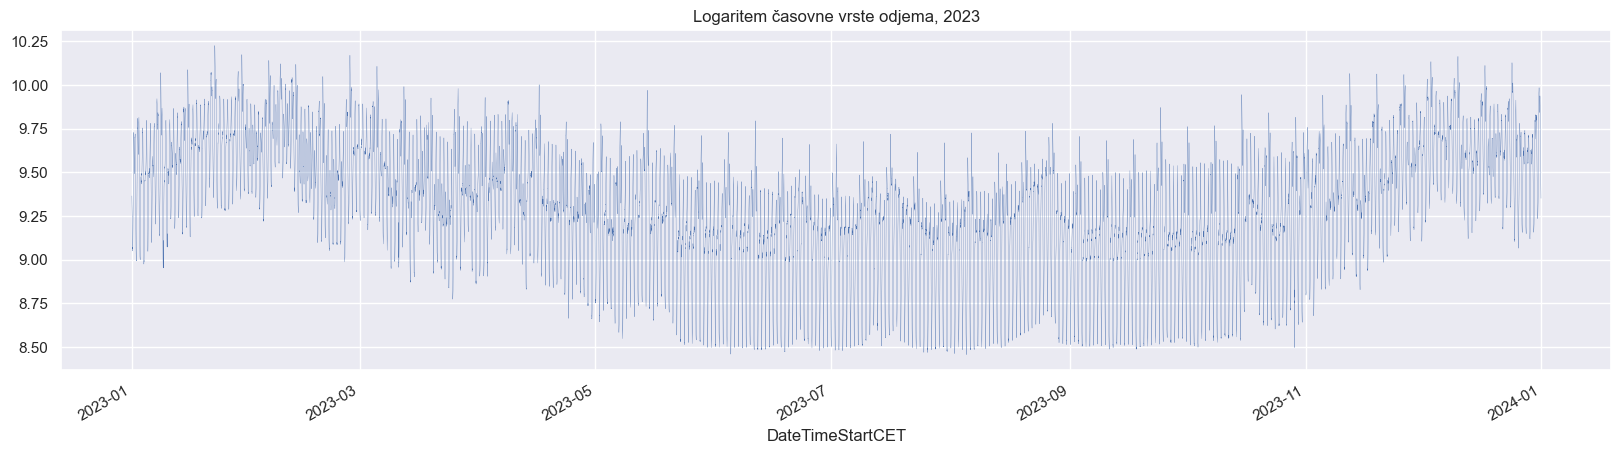

In [53]:
# zaradi velike količine podatkov, se bom osredotočala na leto 2023
podatki.loc['2023', 'Logaritem'].plot(linewidth=0.2) 
plt.title('Logaritem časovne vrste odjema, 2023')

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

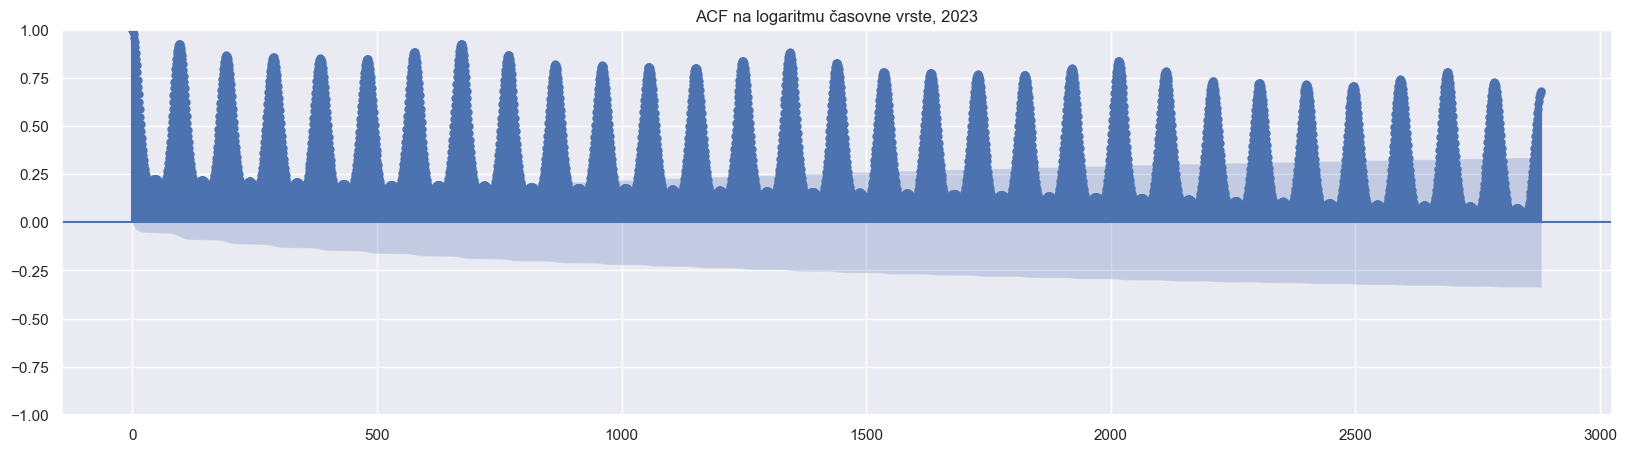

In [55]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, 2023')

# za lag sem vzela 2880, to je ravno 30 dni (96 podatkov na dan * 30 dni)

Text(0.5, 1.0, 'ACF na logaritmu časovne vrste, 2023')

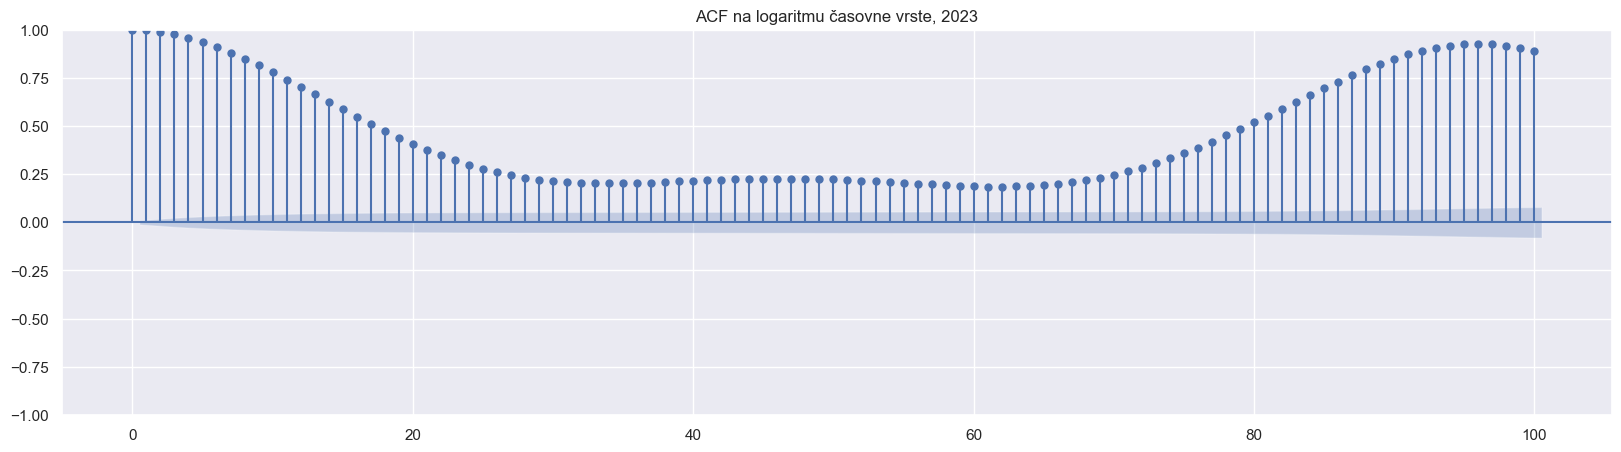

In [65]:
tsaplots.plot_acf(podatki.loc['2023', 'Logaritem'], lags=100)
plt.ylim(-1,1)
plt.title('ACF na logaritmu časovne vrste, zoženo, 2023') # -->sezonskost na vsake 96

In [94]:
# Iz ACF vidimo:
# - stacionarnosti NI
# - smiselno sezonsko komponento -> vse se ponavlja se na 1 dan (96 podatkov)

# da doseženo stacionarno poskusimo DIFERENCIRATI

Text(0.5, 1.0, 'Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

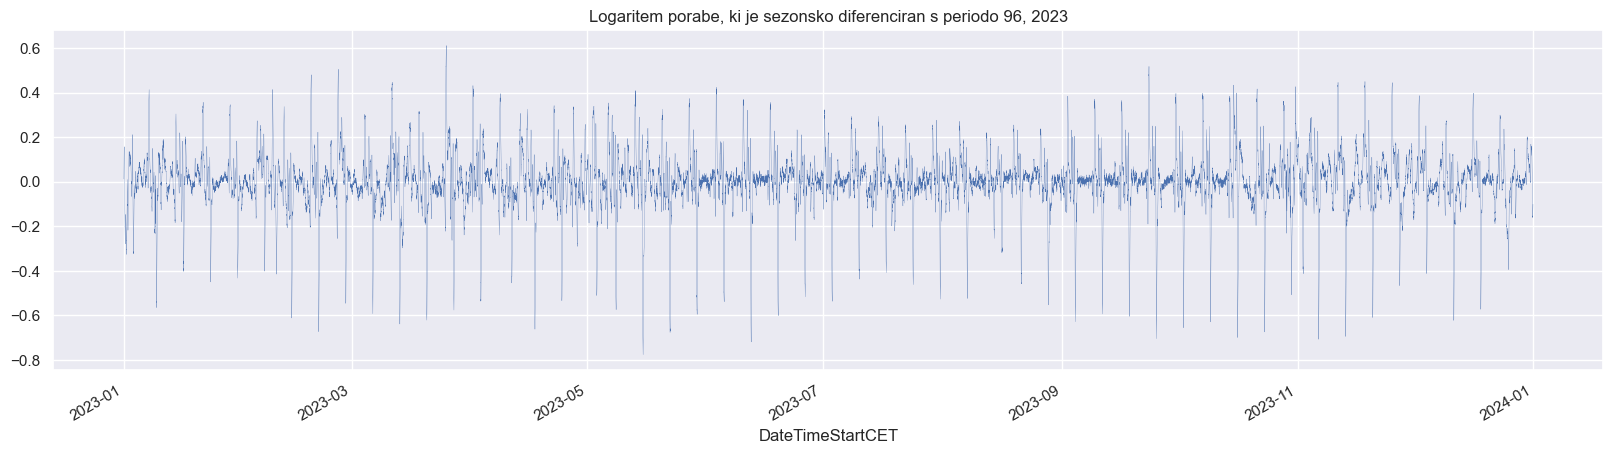

In [10]:
ts_diff = podatki['Logaritem'].diff(periods = 96)
ts_diff['2023'].plot(linewidth=0.2) 
plt.title('Logaritem porabe, ki je sezonsko diferenciran s periodo 96, 2023')

In [ ]:
# opazimo, da je časovna vrsta kar precej bolj stacionarna. Preverimo še ACF

Text(0.5, 1.0, 'ACF po prvem sezonskem diferenciranju, 2023')

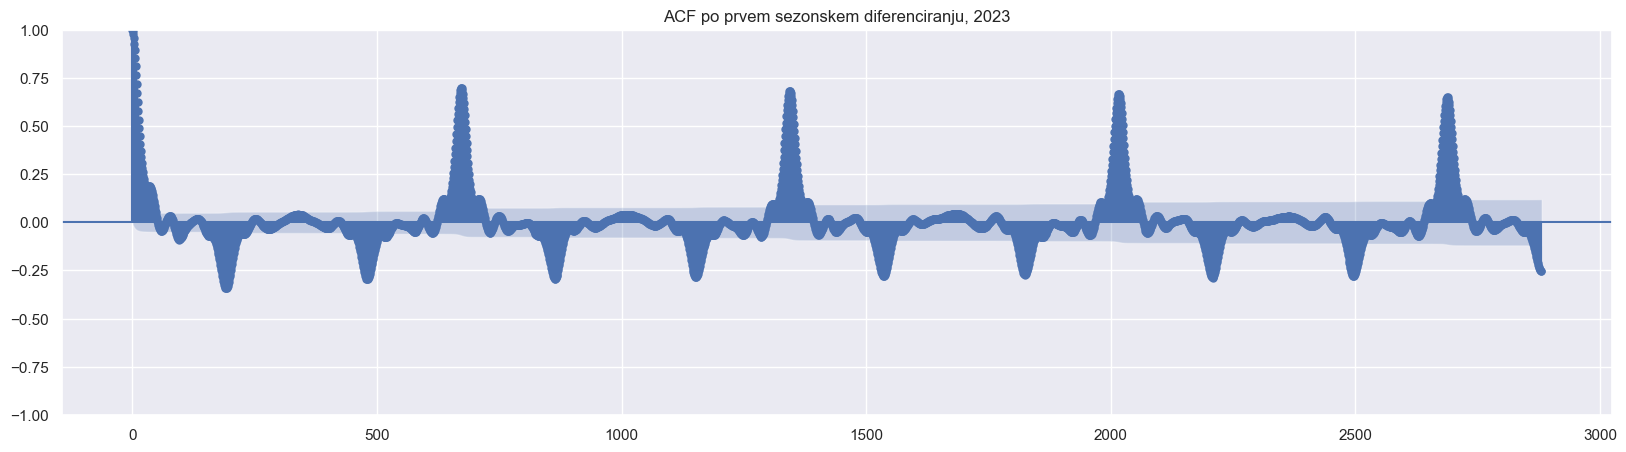

In [67]:
tsaplots.plot_acf(ts_diff['2023'], lags=2880)
plt.ylim(-1,1)
plt.title('ACF po prvem sezonskem diferenciranju, 2023')

In [ ]:
# zgleda stacionarno, ampak diferencirajmo še enkrat

Text(0.5, 1.0, 'Po drugem diferenciranju, 2023')

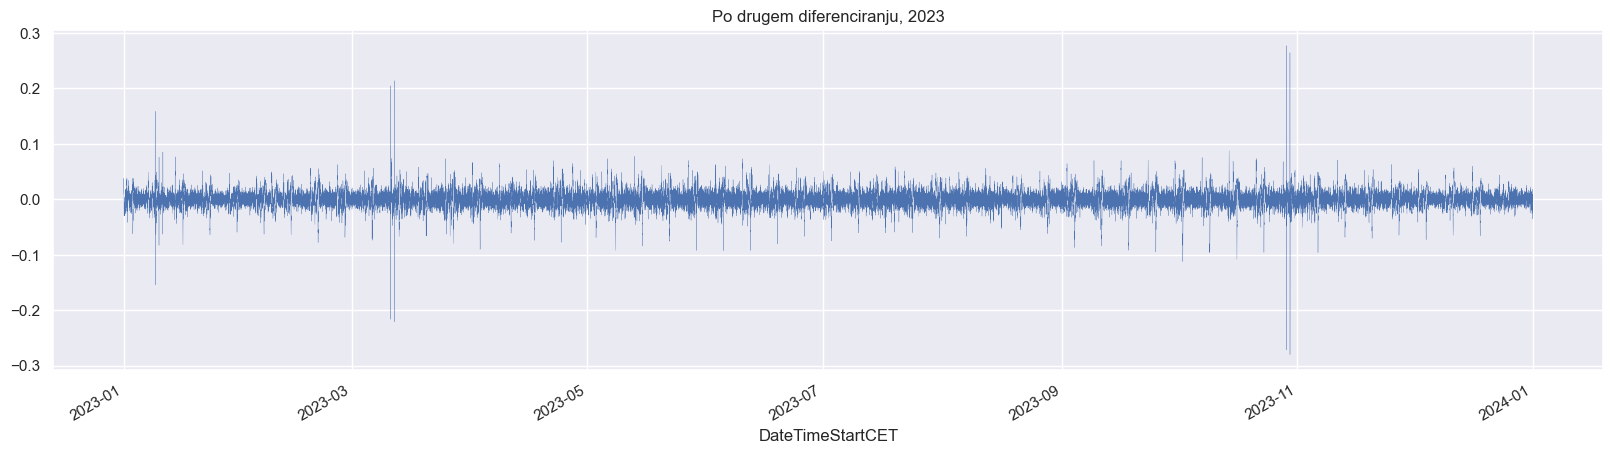

In [11]:
ts_diff2 = ts_diff.diff()
ts_diff2['2023'].plot(linewidth=0.2) 
plt.title('Po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po drugem diferenciranju, 2023')

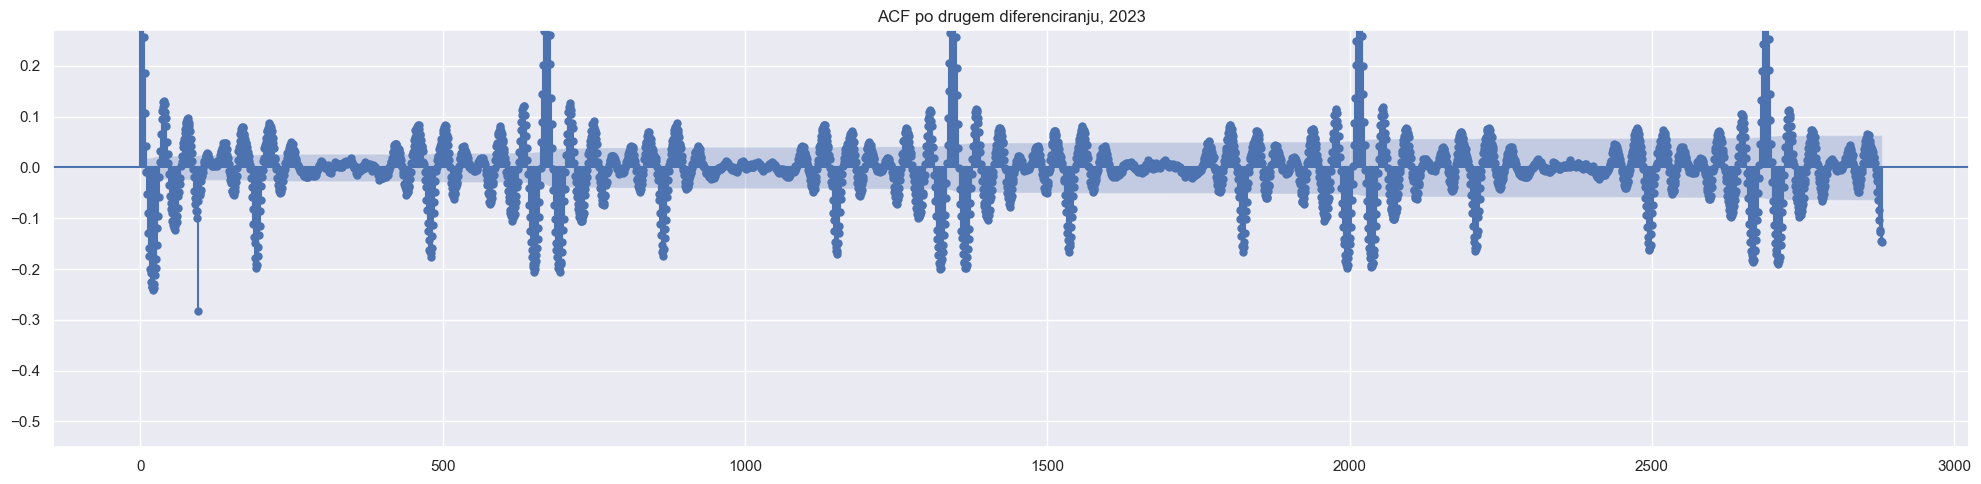

In [82]:
tsaplots.plot_acf(ts_diff2['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po drugem diferenciranju, 2023')

Text(0.5, 1.0, 'Po tretjem diferenciranju, 2023')

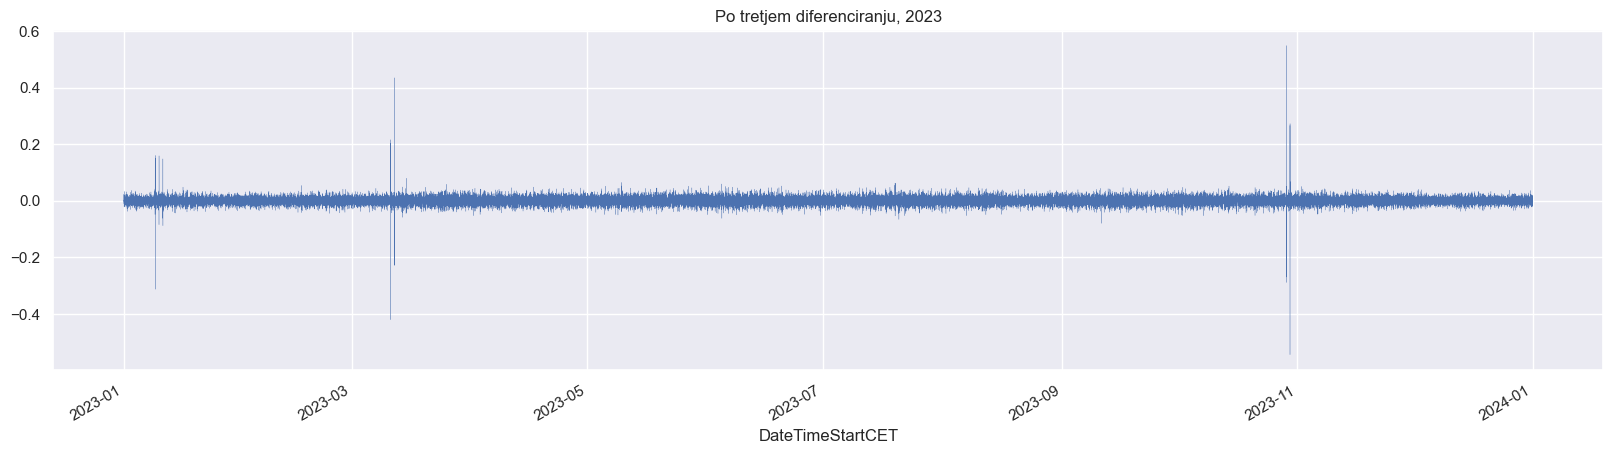

In [12]:
ts_diff3 = ts_diff2.diff()
ts_diff3['2023'].plot(linewidth=0.2) 
plt.title('Po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, 2023')

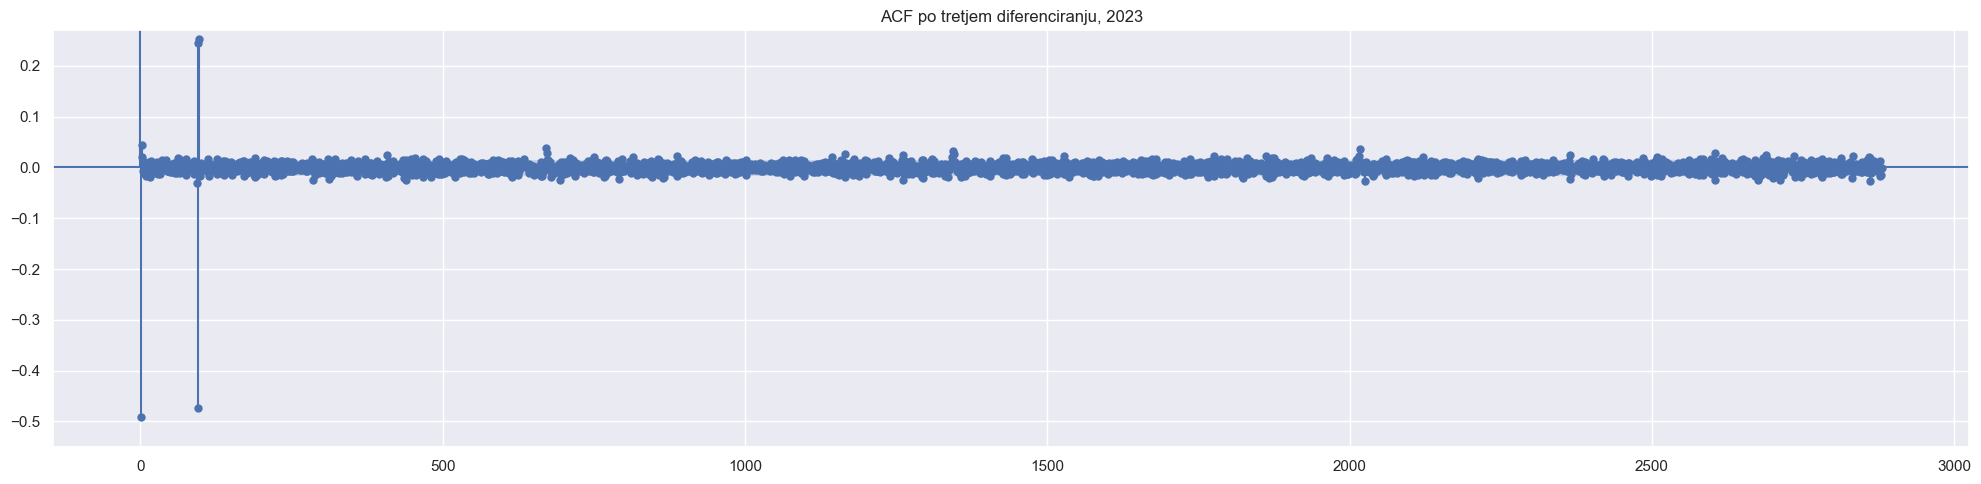

In [85]:
tsaplots.plot_acf(ts_diff3['2023'], lags=2880)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'ACF po tretjem diferenciranju, zožen lag, 2023')

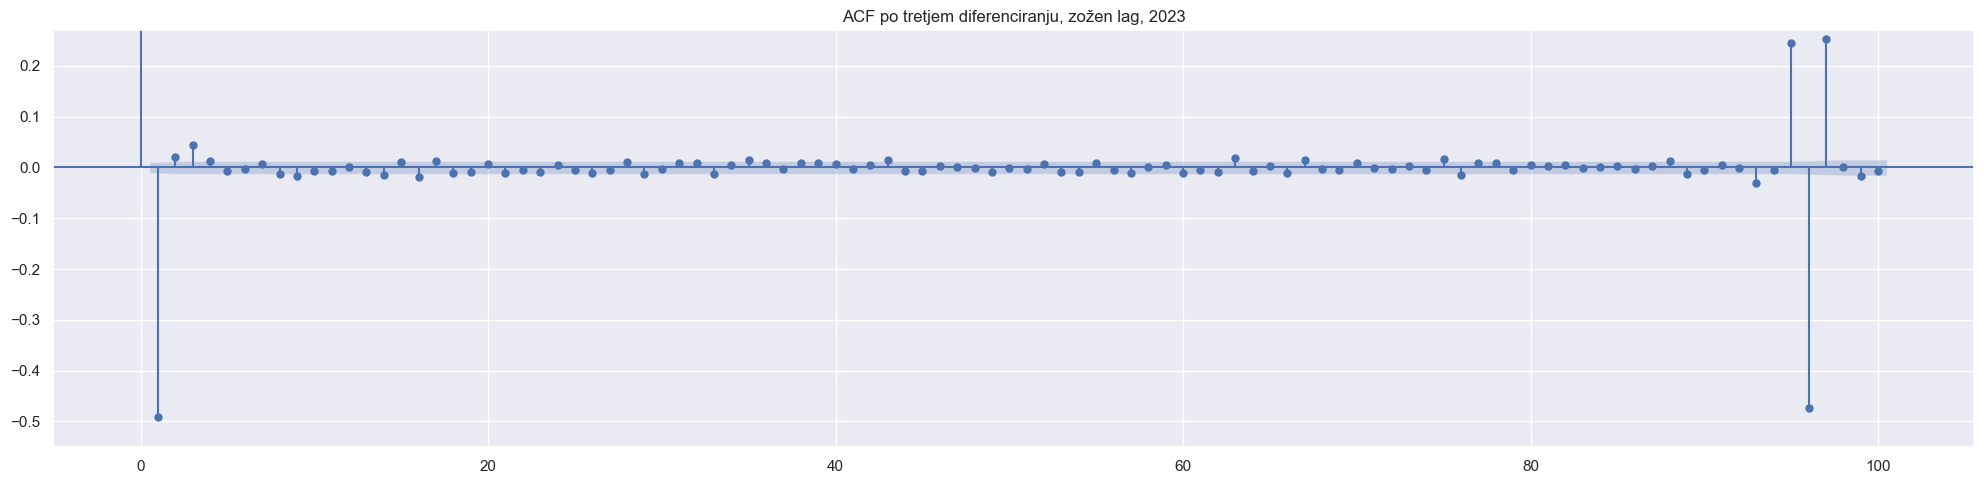

In [86]:
tsaplots.plot_acf(ts_diff3['2023'], lags=100)
plt.ylim(-0.55,0.27)
plt.tight_layout()
plt.title('ACF po tretjem diferenciranju, zožen lag, 2023')

In [87]:
# sedaj zgleda še bolj stacionarno, torej je primerna za model ARMA

# iz ACF se visoko avtokorelacijo opazi pri: 1, 95, 96, 97

# RABIM FORMALNE TESTE?

import statsmodels.tsa.stattools as ts

def test_p_value(data):
        fuller_test = ts.adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Reject null hypothesis, data is stationary')
        else:
            print('Do not reject null hypothesis, data is not stationary')

test_p_value(ts_diff3.dropna())

P-value:  0.0
Reject null hypothesis, data is stationary


Text(0.5, 1.0, 'PACF po tretjem diferenciranju, 2023')

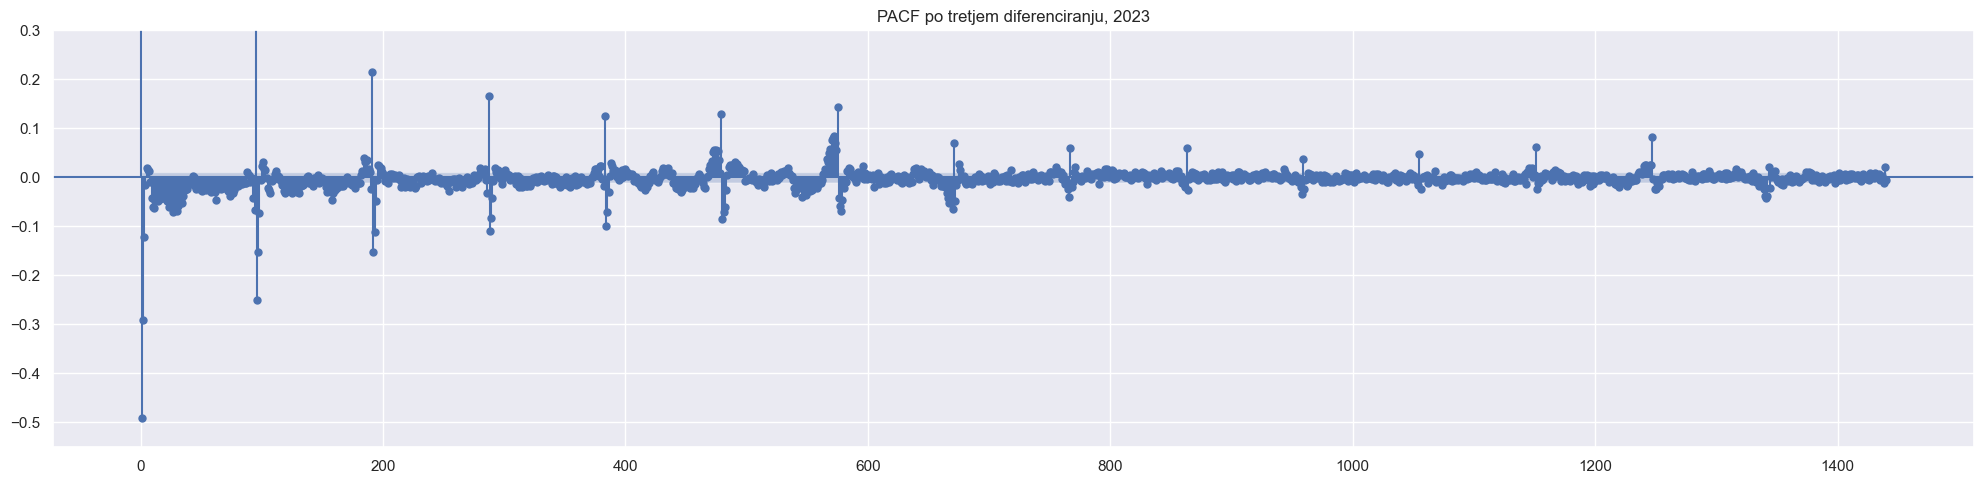

In [90]:
# zaradi izbire modelov si narišemo še PACF

tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=1440, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, 2023')

Text(0.5, 1.0, 'PACF po tretjem diferenciranju, zožen lag, 2023')

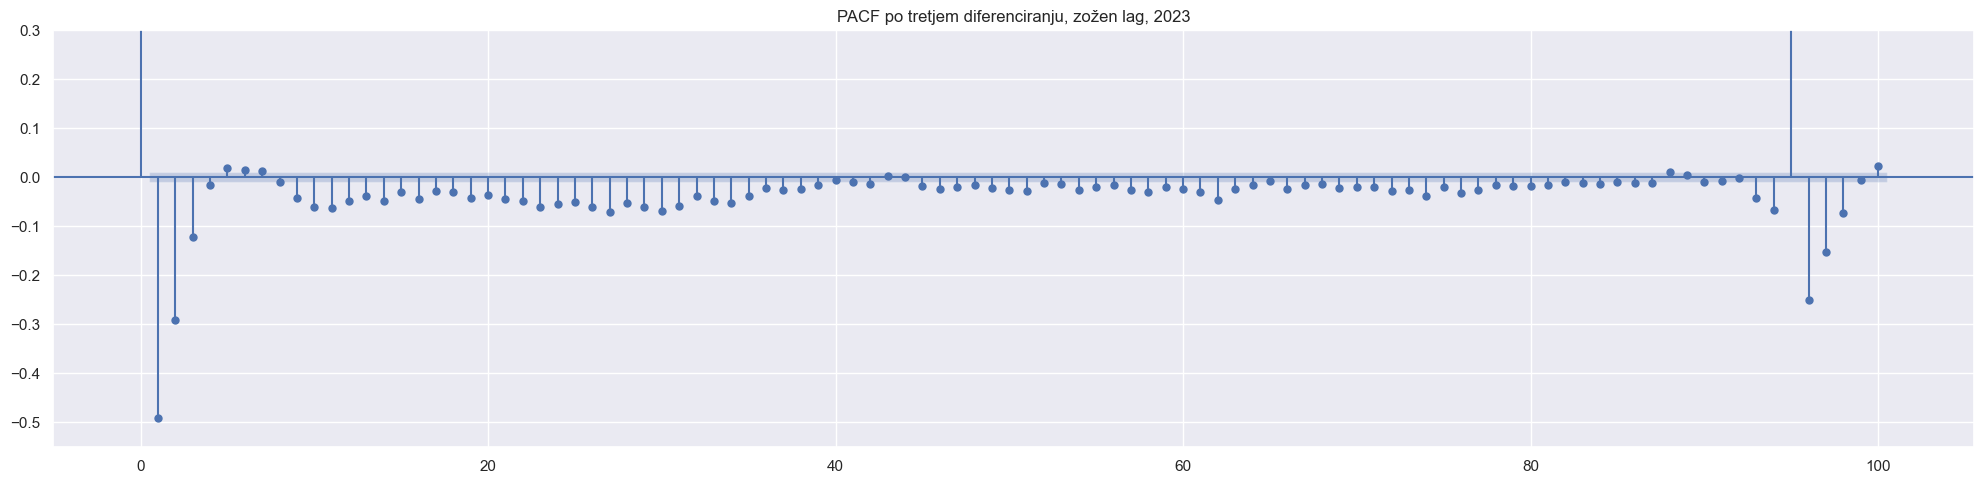

In [23]:
tsaplots.plot_pacf(ts_diff3['2023'].values.squeeze(), lags=100, method="ywm")
plt.ylim(-0.55,0.30)
plt.tight_layout()
plt.title('PACF po tretjem diferenciranju, zožen lag, 2023')

In [ ]:
# visoka korelacije je pri: 1, 2, 3 _____ nato se ponovi pri 95, 191, ... torej se ponovi na 96

# PACF -> AR(p)
# ACF -> MA(q)


# ACF in PACF povesta katere log bi bilo potrebno vključiti
# Zagotovo bomo vključili prvih nekaj meritev/ur, ker imajo večji vpliv
# Koliko dodatnih log-ov bomo še vključili, pa se bomo odločili s pomočjo kriterija AIC

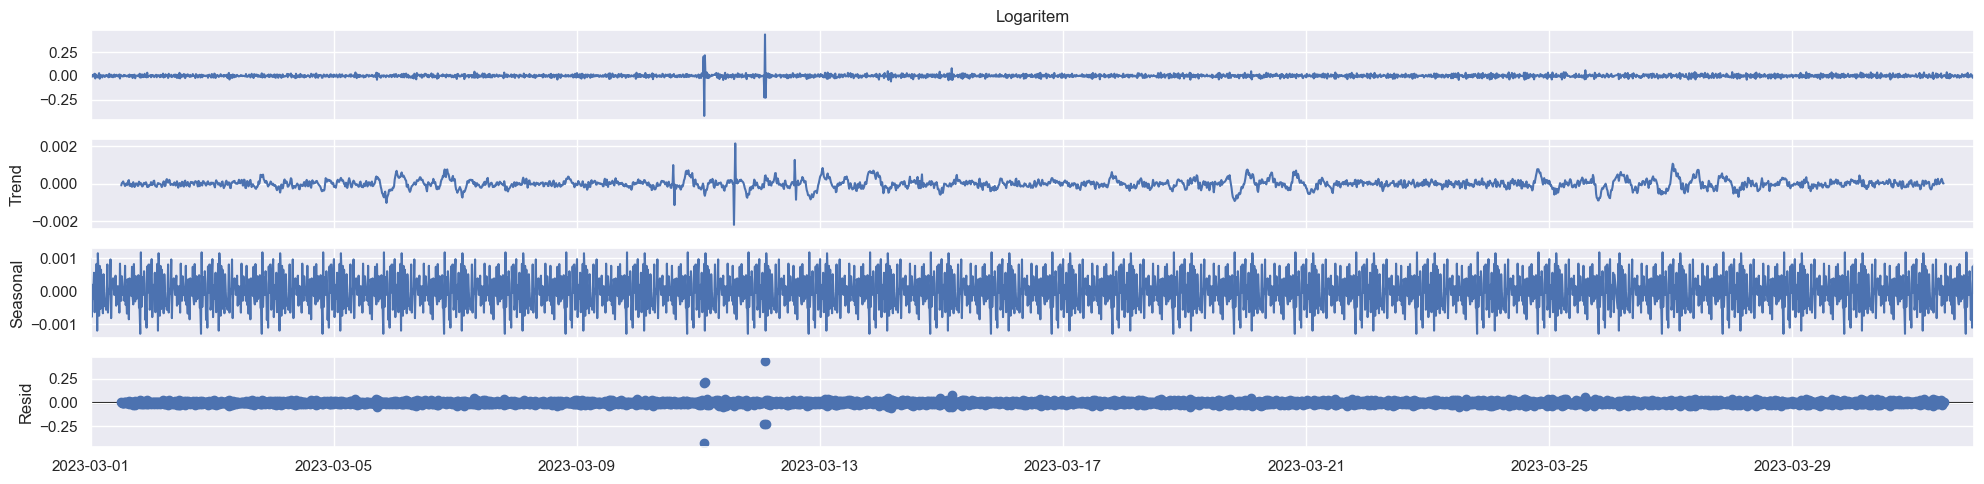

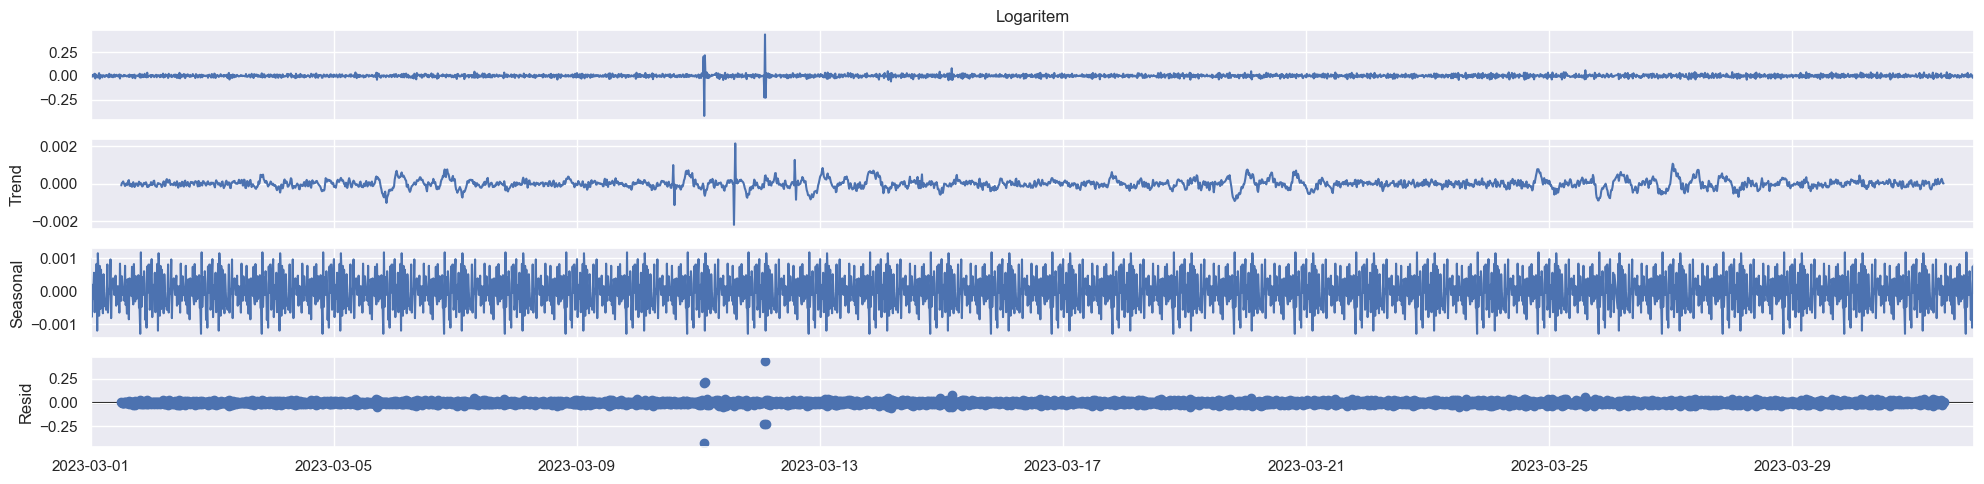

In [93]:
seasonal_decompose(ts_diff3['2023-03'].dropna(), model='additive', period=96).plot()

In [72]:
## MODELI

# da bo šlo bolj hitro se zaenkrat omejimo na samo na dva meseca:
# train data:
train_data = ts_diff3['2023-02-26':'2023-02-28']
train_data_OG = podatki.loc['2023-02-26':'2023-02-28', 'Odjem ACT']
# test data:
test_data = ts_diff3['2023-03-01']
test_data_OG = podatki.loc['2023-03-01', 'Odjem ACT']

In [ ]:
# uporabljam SARIMA ker imam sezonsko konponento

# !! PRIMERJAVA MED SARIMA in ARIMA !!

In [62]:
# # Constructing the ARIMA model

# from statsmodels.tsa.arima_model import ARIMA

# model = sm.tsa.statespace.SARIMAX(train_data, order=(0,1,0), seasonal_order=(1,1,1,96))
# results = model.fit()
# results.summary()

In [95]:
# Constructing the ARIMA model

from statsmodels.tsa.arima_model import ARIMA

model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,2,0), seasonal_order=(1,2,1,96))
results = model.fit()
results.summary()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Odjem ACT   No. Observations:                  672
Model:             SARIMAX(0, 2, 0)x(1, 2, [1], 96)   Log Likelihood               -3294.309
Date:                              Sun, 12 May 2024   AIC                           6594.618
Time:                                      23:43:11   BIC                           6607.126
Sample:                                  02-22-2023   HQIC                          6599.535
                                       - 02-28-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L96      -0.3857      0.057     -6.755      0.000      -0.498      -0.274
ma.S.L96      -0.9976     19.508     -0.051      0.959     -39.233      37.238
sigma2      3.556e+04   6.92e+05      0.051      0.959   -1.32e+06    1.39e+06
===================================================================================
Ljung-Box (L1) (Q):                  52.08   Jarque-Bera (JB):                20.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.21
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# ARIMA:
model_1 = sm.tsa.statespace.SARIMAX(train_data_OG, order=(0,0,0), simple_differencing=True)# order=(1,2,1))
results_1 = model.fit()
results_1.summary()

KeyboardInterrupt: 

In [18]:
model = sm.tsa.statespace.SARIMAX(train_data_OG, order=(3,2,1), seasonal_order=(1,2,1,96))
results = model.fit()
results.summary()

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  self._init_dates(dates, freq)
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Odjem ACT   No. Observations:                  672
Model:             SARIMAX(3, 2, 1)x(1, 2, 1, 96)   Log Likelihood               -3258.749
Date:                            Mon, 13 May 2024   AIC                           6531.497
Time:                                    12:24:40   BIC                           6560.685
Sample:                                02-22-2023   HQIC                          6542.972
                                     - 02-28-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3975     51.019     -0.027      0.978    -101.394      98.599
ar.L2         -0.5888     20.294     -0.029      0.977     -40.363      39.186
ar.L3         -0.1910      9.751     -0.020      0.984     -19.303      18.921
ma.L1          0.9996     53.919      0.019      0.985    -104.680     106.679
ar.S.L96      -0.3225      0.042     -7.753      0.000      -0.404      -0.241
ma.S.L96      -0.9977      2.906     -0.343      0.731      -6.693       4.697
sigma2       3.13e+04      0.001   4.81e+07      0.000    3.13e+04    3.13e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                37.80
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.26
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+26. Standard errors may be unstable.
"""

<AxesSubplot: xlabel='DateTimeStartCET'>

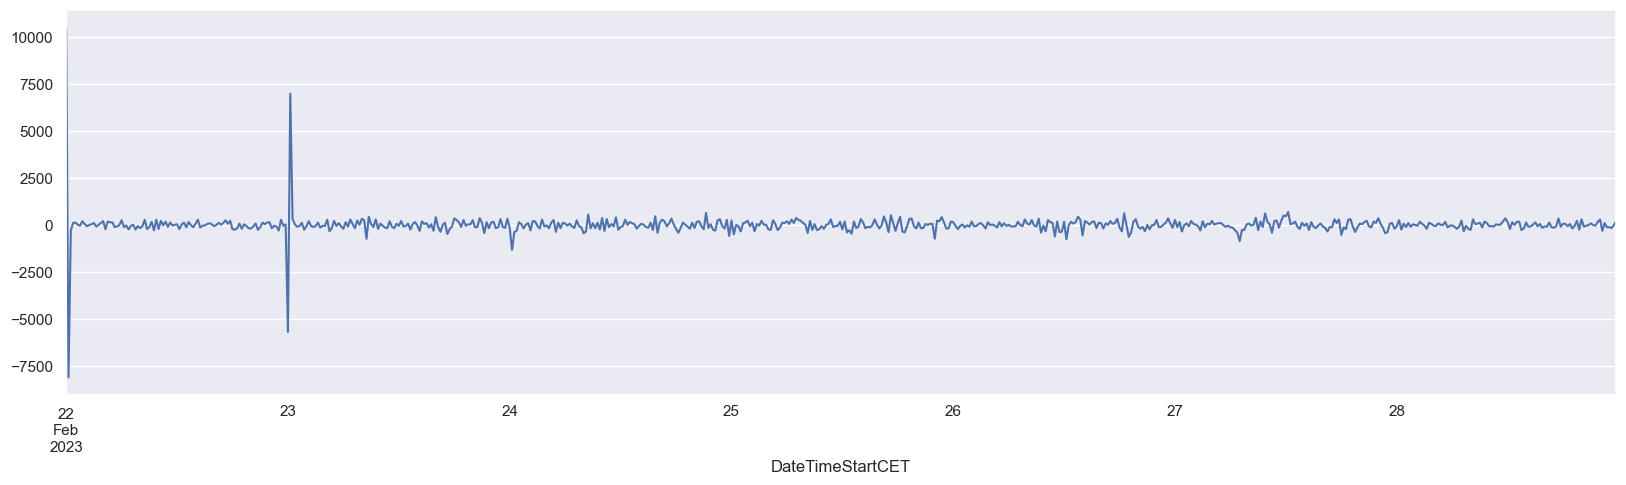

In [19]:
results.resid.plot()

Text(0.5, 1.0, 'ACF za SARIMAX, 2023')

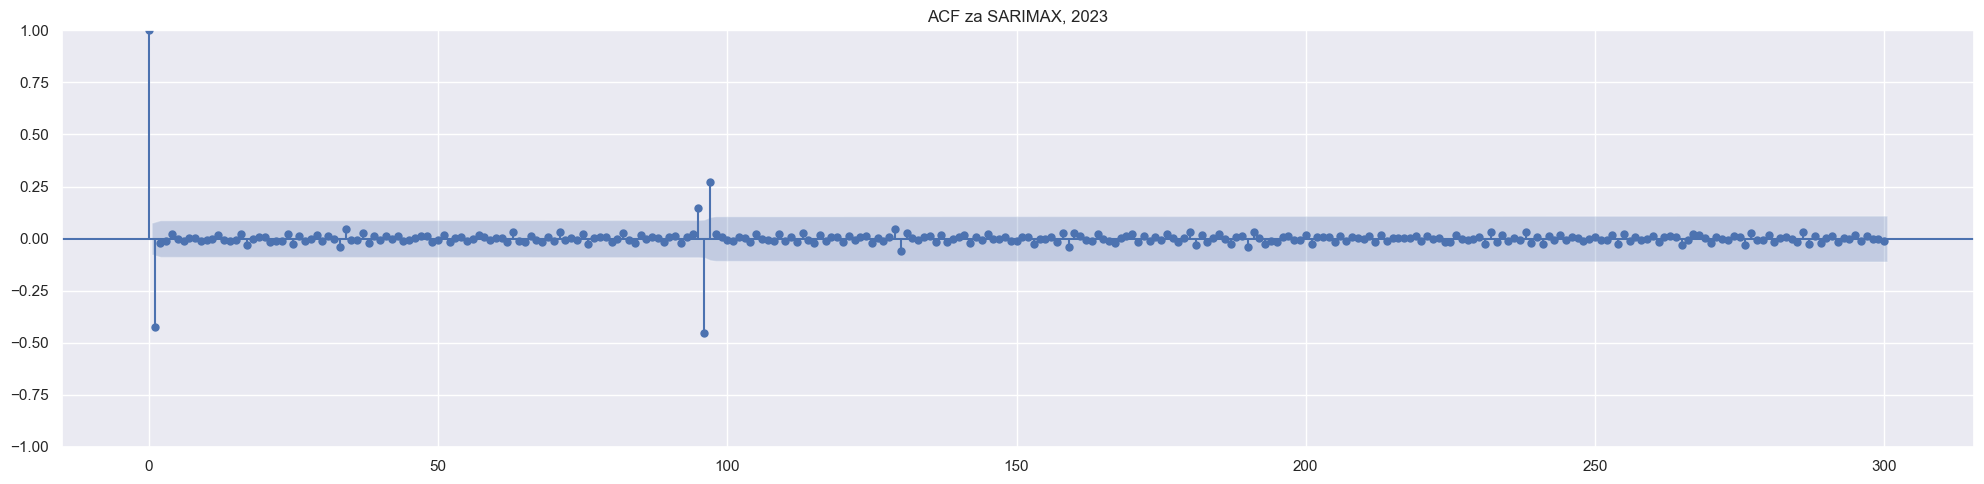

In [20]:
tsaplots.plot_acf(results.resid.values.squeeze(), lags=300)
plt.ylim(-1,1)
plt.tight_layout()
plt.title('ACF za SARIMAX, 2023')

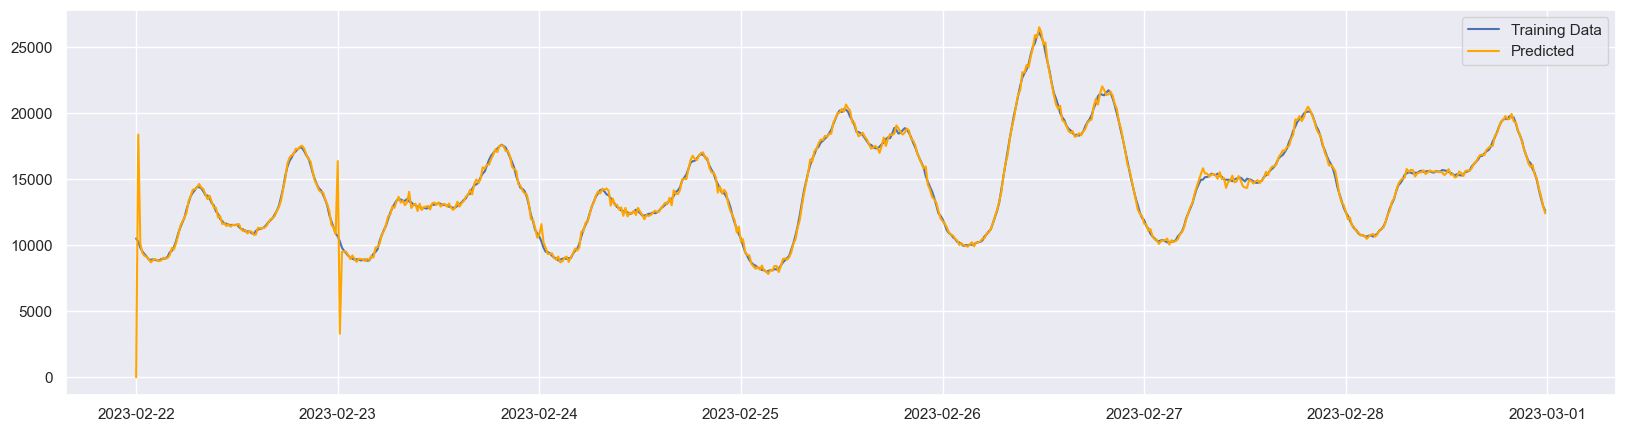

In [21]:
# df['prediction'] = 
results.predict()
# >>> df[['Production','prediction']].plot(figsize=(12,8))

plt.plot(train_data_OG, label='Training Data')
plt.plot(results.predict(), label='Predicted', color='orange')
plt.legend()

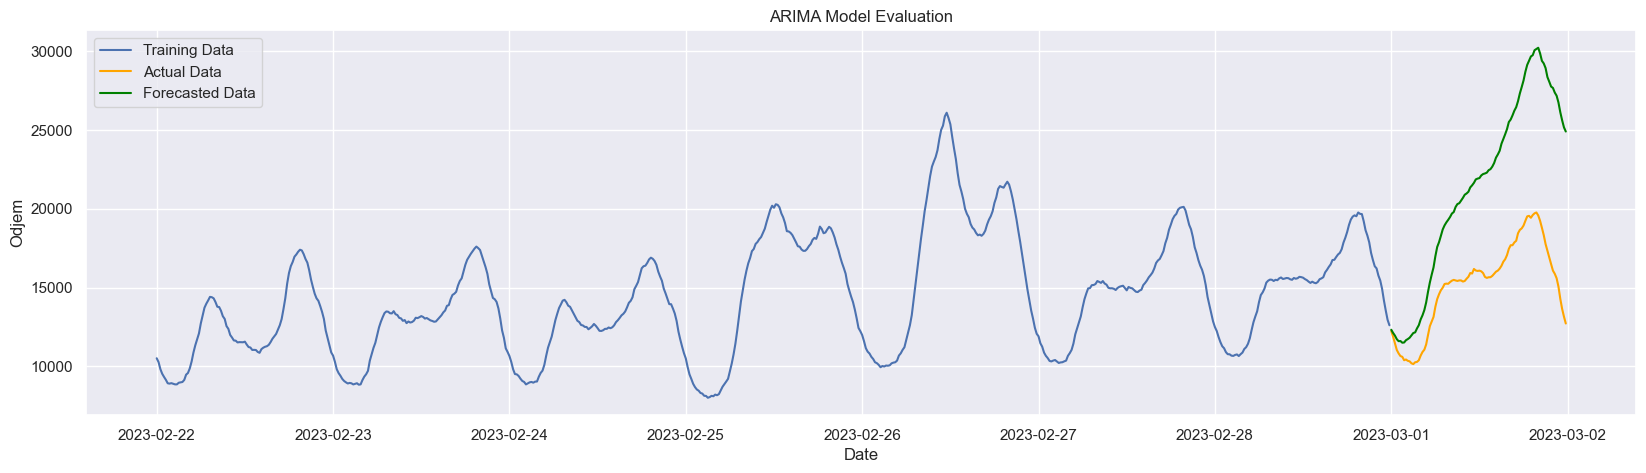

In [22]:
# FORECAST on the test dataset
test_forecast = results.get_forecast(steps=96)
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# narišemo
plt.plot(train_data_OG, label='Training Data')
plt.plot(test_data_OG, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Odjem')
plt.legend()
plt.show()

In [81]:
# from pmdarima import auto_arima

# model = auto_arima(
#             y                 = train_data_OG,
#             start_p           = 0,
#             start_q           = 0,
#             max_p             = 3,
#             max_q             = 1,
#             seasonal          = True,
#             test              = 'adf',
#             m                 = 96, # Seasonal period
#             d                 = None, # The algorithm will determine 'd'
#             D                 = None, # The algorithm will determine 'D'
#             trace             = True,
#             error_action      = 'ignore',
#             suppress_warnings = True,
#             stepwise          = True
#         )


# PRVEČ ČASOVNO ZAHTEVNO ZA MOJ RAČUNALNIČEK :(

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[96] intercept   : AIC=inf, Time=70.77 sec
 ARIMA(0,0,0)(0,0,0)[96] intercept   : AIC=1062.278, Time=3.34 sec
 ARIMA(1,0,0)(1,0,0)[96] intercept   : AIC=968.266, Time=50.31 sec
 ARIMA(0,0,1)(0,0,1)[96] intercept   : AIC=990.689, Time=18.82 sec
 ARIMA(0,0,0)(0,0,0)[96]             : AIC=2350.578, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[96] intercept   : AIC=976.611, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[96] intercept   : AIC=966.955, Time=273.26 sec
 ARIMA(1,0,0)(2,0,1)[96] intercept   : AIC=inf, Time=376.82 sec
 ARIMA(1,0,0)(1,0,1)[96] intercept   : AIC=inf, Time=89.29 sec
 ARIMA(0,0,0)(2,0,0)[96] intercept   : AIC=inf, Time=238.61 sec


MemoryError: Unable to allocate 193. MiB for an array with shape (194, 194, 673) and data type float64

In [ ]:



## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================
## ==============================================================================================================================================================================================




In [ ]:
## MULTIVARIATE MODEL

# najprej si poglejmo povezavo med temperaturo in odjemom

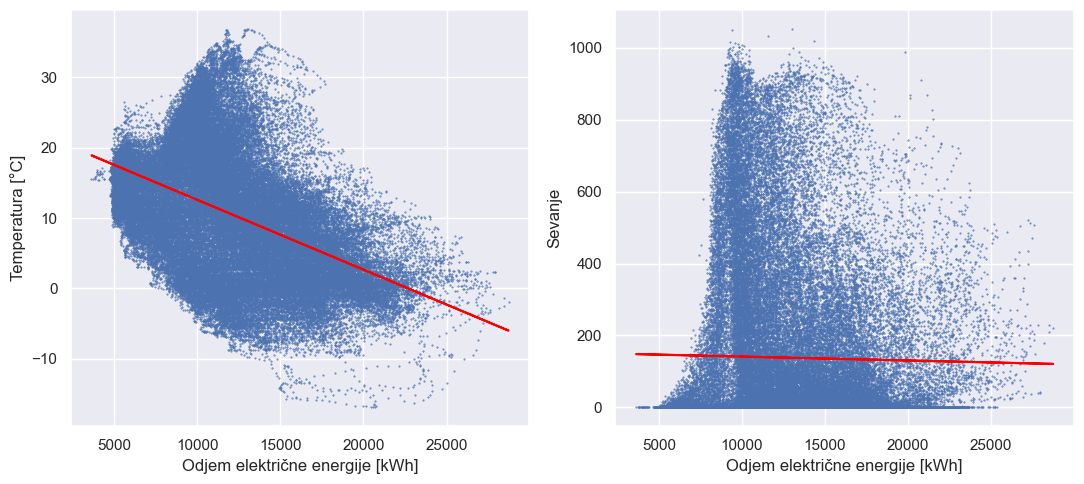

In [101]:
# Povezava med temperaturo in odjemom:

# temperatura
X = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y = np.array(podatki["Temperatura ACT"])
reg = LinearRegression().fit(X, y)
podatki['predicted'] = reg.predict(X)

# sevanje
X_S = np.array(podatki["Odjem ACT"]).reshape(-1, 1)
y_S = np.array(podatki["Sevanje ACT"])
reg = LinearRegression().fit(X_S, y_S)
podatki['predicted_S'] = reg.predict(X_S)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11, 5))

ax1 = plt.subplot(1, 2, 1)
podatki.plot.scatter(x = "Odjem ACT", y = "Temperatura ACT", s = 0.2, ax = ax1, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted', ax = ax1, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Temperatura [°C]')

ax1 = plt.subplot(1, 2, 2)
podatki.plot.scatter(x = "Odjem ACT", y = "Sevanje ACT", s = 0.2, ax = ax2, legend=False)
podatki.plot.line(x = "Odjem ACT", y = 'predicted_S', ax = ax2, color="red", legend=False)
plt.xlabel('Odjem električne energije [kWh]')
plt.ylabel('Sevanje')

plt.tight_layout()


In [ ]:
# opazna je povezava --> ?? FORMALNO JE TREBA ŠE PREVERITI KORELIRANOST in te zavedice ??

# sevanja verjetno ne bom uporabljala ??